### Experimental Parameters

In [3]:
proposal_rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
n_trials = 5

### Setup JSON File

In [4]:
import json

# Create experimental parameters and write to JSON file

params = {'Block proposal rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 1200,
 'Fork choice rule': 'longest-chain',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson'}
d = {}
for i in range(0, len(proposal_rates)):
    params['Block proposal rate parameter'] = proposal_rates[i]
    d[f'longest-chain-{i}'] = params


### Run experiments

In [5]:
import os, shutil

os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
finalization_latencies = {}

for i in range(0, len(proposal_rates)):
    rate = proposal_rates[i]
    d['setting-name'] = f'longest-chain-{i}'
    with open('results/longest_chain.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[rate] = []
    main_chain_arrival_latencies[rate] = []
    finalization_latencies[rate] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/longest_chain.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[rate].append(throughput)
        main_chain_arrival_latencies[rate].append(avg_main_chain_arrival_latency)
        finalization_latencies[rate].append(avg_finalization_latency)
        

os.chdir('results/')
os.remove('longest_chain.json')

print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Throughputs:
 {0.05: [1, 1, 1, 1, 1], 0.1: [1, 1, 1, 1, 1], 0.15: [1, 1, 1, 1, 1], 0.2: [1, 1, 1, 1, 1], 0.25: [1, 1, 1, 1, 1], 0.3: [1, 1, 1, 1, 1], 0.35: [1, 1, 1, 1, 1], 0.4: [1, 1, 1, 1, 1], 0.45: [1, 1, 1, 1, 1], 0.5: [1, 1, 1, 1, 1]}
Main Chain Arrival Latencies:
 {0.05: [3.9794970266359058, 4.5316412456698885, 4.0859104998529165, 4.2961161549943085, 4.642417475407695], 0.1: [4.61842582632633, 4.173350883413162, 4.2874699526207465, 4.188173520733319, 4.6028435758397315], 0.15: [4.572766493612813, 4.2832674676051345, 4.694423083899841, 4.131516093713944, 4.43906261251718], 0.2: [4.527069117052531, 4.544205173817729, 4.063221498941026, 4.2148269105596485, 3.686715562843364], 0.25: [4.094187636725049, 4.441764781312735, 4.26074076115641, 4.159042748431427, 3.728470640377277], 0.3: [4.380183767956392, 4.161878613890128, 3.892882343807535, 4.793763853037789, 4.520951094239849], 0.35: [4.356179033039684, 4.526644598232321, 4.182055421381868, 4.321708278354154, 4.050107314028126], 0.4: 

### Compute Averages

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was created.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [6]:
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)
avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)


Average Main Chain Arrival Latency: {0.05: 4.307116480512143, 0.1: 4.374052751786658, 0.15: 4.424207150269782, 0.2: 4.207207652642859, 0.25: 4.13684131360058, 0.3: 4.349931934586339, 0.35: 4.28733892900723, 0.4: 4.2098548946172105, 0.45: 4.3638812613417866, 0.5: 4.343492215186723}
Average Finalization Latency: {0.05: 4.624935401752261, 0.1: 4.617501671566298, 0.15: 4.709515220845623, 0.2: 4.663311671427176, 0.25: 4.694466905428903, 0.3: 4.822111403762139, 0.35: 4.757141347298557, 0.4: 4.542030595214156, 0.45: 4.741804125339737, 0.5: 4.683420463883581}


### Plotting the results

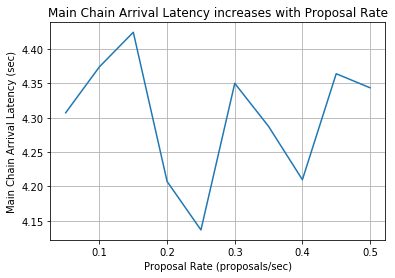

In [8]:
import matplotlib.pylab as plt

x = avg_main_chain_latencies.keys()
y1 = avg_main_chain_latencies.values()
y2 = avg_finalization_latencies.values()

plt.xlabel('Proposal Rate (proposals/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title('Main Chain Arrival Latency increases with Proposal Rate')
plt.grid(True)

plt.plot(x, y1)
plt.show()

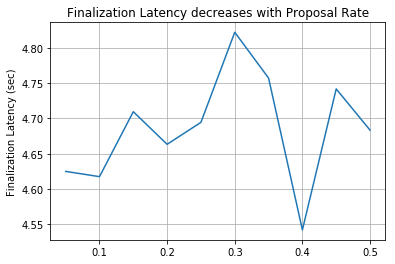

In [9]:
plt.title('Finalization Latency decreases with Proposal Rate')
plt.ylabel('Finalization Latency (sec)')
plt.grid(True)

plt.plot(x, y2)
plt.show()